> RFM 기법

- Recency : 가장 최근 상품 구입 일에서 오늘까지의 기간
- Frequency : 상품 구매 횟수, 특정 기간 동안 얼마나 자주 서비스를 이용하는지
- Monetary Value : 총 구매 금액

### **Data Set Loading & Data Cleansing**

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

retail_df = pd.read_excel('/content/drive/MyDrive/Kaggle - 파이썬 머신러닝 완벽 가이드/kaggleData/Online Retail.xlsx')
retail_df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


>- InvoiceNo: 주문번호 (C로 시작하는 것은 취소 주문)
- StockCode: 제품 코드
- Description: 제품 설명
- Quantity: 주문 제품 건수
- InvoiceDate: 주문 일자
- UnitPrice: 제품 단가
- CustomerID: 고객 번호
- Country: 주문 고객의 국적

In [32]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [33]:
# Null data 제거 => 고객 segmentation을 하는데, 고객 번호가 없는 data는 필요가 없기에 삭제
# 오류 data 삭제 => Quantity / Unitprice가 0보다 작은 경우
# Quantity가 0보다 작음 : 반환을 뜻함 => Invoice Num 앞자리가 'C'임 -> 분석의 효율성을 위해 삭제
# Boolean Indexing을 적용
retail_df = retail_df[retail_df['Quantity']>0]
retail_df = retail_df[retail_df['UnitPrice']>0]
retail_df = retail_df[retail_df['CustomerID'].notnull()]
print(retail_df.shape)
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

> **RFM 기반 데이터 가공**

In [34]:
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

In [35]:
print('총 주문 건수')
print(retail_df['CustomerID'].value_counts().head(5))
print('총 주문 금액')
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending = False)[:5])

총 주문 건수
17841    7847
14911    5675
14096    5111
12748    4595
14606    2700
Name: CustomerID, dtype: int64
총 주문 금액
CustomerID
14646    280206.02
18102    259657.30
17450    194550.79
16446    168472.50
14911    143825.06
Name: sale_amount, dtype: float64


In [36]:
# 식별자 : 주문 번호 + 상품 코드 => unique한 identifier가 될 수 있는지 확인
retail_df.groupby(['InvoiceNo', 'StockCode'])['InvoiceNo'].count().mean()

1.0258946320786095

In [37]:
# 주문 번호 기준의 data를 개별 고객 기준('Customer ID')의 data로 groupby 해주어야 함

# DataFrame의 groupby() 의 multiple 연산을 위해 agg() 이용 => 대상 column, aggregation 함수명을 딕셔너리 형태로 입력
# Recency는 InvoiceDate 컬럼의 max() 에서 데이터 가공
# Frequency는 InvoiceNo 컬럼의 count() , Monetary value는 sale_amount 컬럼의 sum()

aggregations = {
    'InvoiceDate' : 'max',
    'InvoiceNo' : 'count',
    'sale_amount' : 'sum'
}

cust_df = retail_df.groupby('CustomerID').agg(aggregations)
# groupby된 결과 칼럼 값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate':'Recency',
                                    'InvoiceNo':'Frequency',
                                    'sale_amount':'Monetary'})
cust_df = cust_df.reset_index()
cust_df.head(5)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12347,2011-12-07 15:52:00,182,4310.00
2,12348,2011-09-25 13:13:00,31,1797.24
3,12349,2011-11-21 09:51:00,73,1757.55
4,12350,2011-02-02 16:01:00,17,334.40


In [38]:
# 이 data가 2010년 12월 1일부터 9일까지의 data이기에, 2010.12.10을 현재 날짜로 간주하고 예측을 수행
# 실제 오늘 날짜로 data를 전처리 하면 절대 안 된다
# days만 추출
import datetime as dt

cust_df['Recency'] = dt.datetime(2011,12,10) - cust_df['Recency']
cust_df['Recency'] = cust_df['Recency'].apply(lambda x : x.days+1)
print('cust_df 로우와 칼럼 건수는', cust_df.shape)
cust_df.head(3)

cust_df 로우와 칼럼 건수는 (4338, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,3,182,4310.00
2,12348,76,31,1797.24


>### **RFM 기반 고객 Segmentation**

- 온라인 판매 data set은 소매업체의 대규모 주문을 포함하고 있다.
- 주문 횟수와 주문 금액에서 개인 고객 주문과는 매우 큰 차이를 나타내고 있으며 이로 인해 매우 왜곡된 데이터 분포도를 가지게 되어 군집화가 한쪽 군집에만 집중되는 현상이 발생
- **먼저 온라인 판매 data set의 칼럼별 히스토그램을 확인하고, 이처럼 왜곡된 데이터 분포도에서 군집화를 수행할 때 어떤 현상이 발생하는 지 알아본다.**

(array([4.303e+03, 1.800e+01, 9.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([3.75000000e+00, 2.80239770e+04, 5.60442040e+04, 8.40644310e+04,
        1.12084658e+05, 1.40104885e+05, 1.68125112e+05, 1.96145339e+05,
        2.24165566e+05, 2.52185793e+05, 2.80206020e+05]),
 <BarContainer object of 10 artists>)

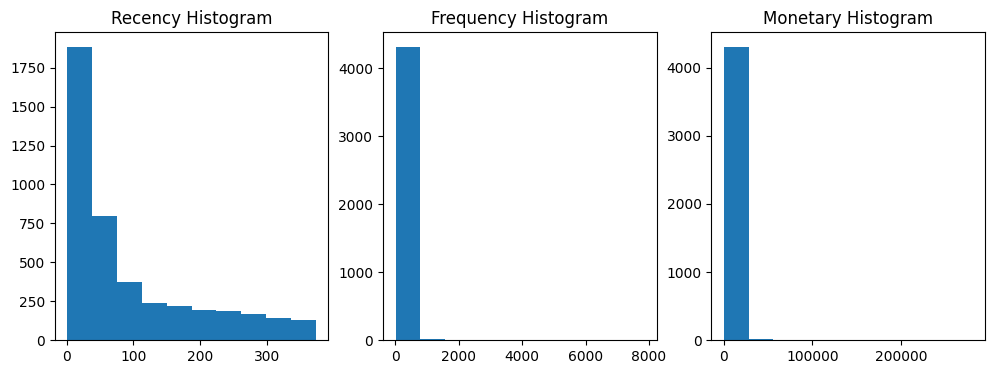

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12,4), nrows = 1, ncols = 3)
ax1.set_title('Recency Histogram')
ax1.hist(cust_df['Recency'])

ax2.set_title('Frequency Histogram')
ax2.hist(cust_df['Frequency'])

ax3.set_title('Monetary Histogram')
ax3.hist(cust_df['Monetary'])

=> Frequency, Monetary의 경우 특정 범위에 값이 몰려 있어서 왜곡 정도가 매우 심함을 알 수 있다.

In [40]:
cust_df[['Recency','Frequency','Monetary']].describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,93.059474,91.720609,2054.266460
std,100.012264,228.785094,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,307.415000
50%,51.000000,41.000000,674.485000
75%,142.750000,100.000000,1661.740000
max,374.000000,7847.000000,280206.020000


In [41]:
# data set을 standardscaler로 평균, 표준편차를 재조정한 후, kㅡmeans 클러스터링을 수행
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters = 3, random_state = 0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.602


=> 실루엣 계수는 0.5 이상일 때 해당 클러스터링 결과가 상당히 적절하다고 간주한다. 이 값이 1에 가까울수록 클러스터 간의 거리가 멀고 클러스터 내의 데이터 포인트가 밀집되어 있음을 나타낸다. 그러나, 실제로 군집 개수를 변화시켜보며, 군집 개수 별로 군집화 구성을 시각화 해보면

In [42]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(cluster_lists, X_features):

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        # y축 눈금을 비활성화
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현.
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")

In [43]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 클러스터링 결과를 시각화
def visualize_kmeans_plot_multi(cluster_lists, X_features):

    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np

    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성
    n_cols = len(cluster_lists)
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 입력 데이터의 FEATURE가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    pca = PCA(n_components=2)
    pca_transformed = pca.fit_transform(X_features)
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])

     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(pca_transformed)
        dataframe['cluster']=cluster_labels

        unique_labels = np.unique(clusterer.labels_)
        markers=['o', 's', '^', 'x', '*']

        # 클러스터링 결과값 별로 scatter plot 으로 시각화
        for label in unique_labels:
            label_df = dataframe[dataframe['cluster']==label]
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)

        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))
        axs[ind].legend(loc='upper right')

    plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

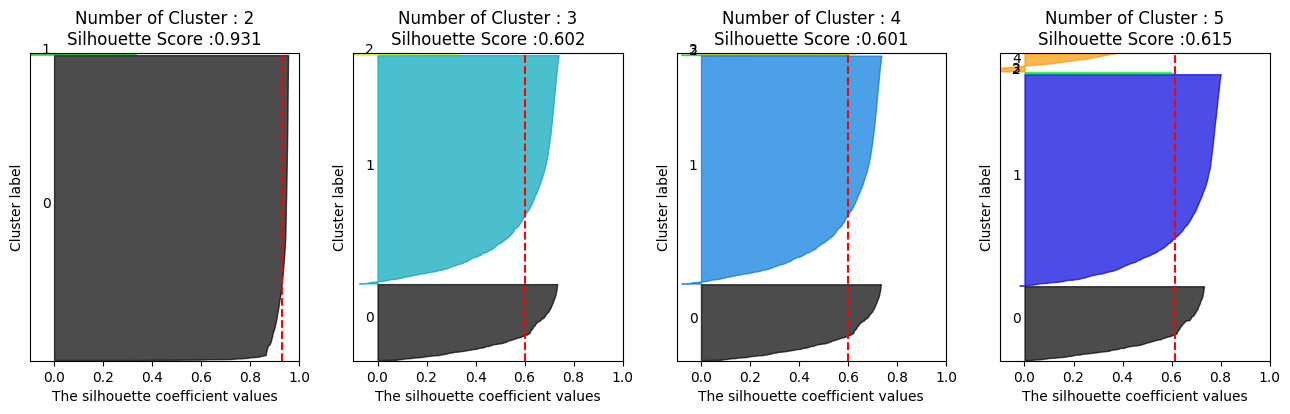

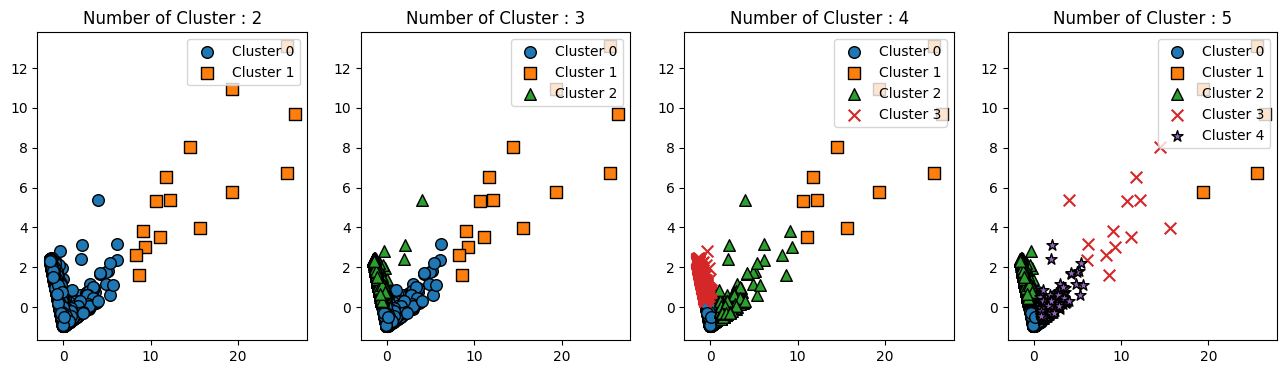

In [44]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

- 2개의 군집으로 군집화한 결과를 보면, 너무 개괄적으로 군집화가 되었음을 알 수 있다. 군집화가 충분히 세밀하게 이루어지지 않았거나 군집 간의 경계가 모호하여 데이터의 특성을 잘 파악하기 어렵다는 뜻이다.
- 그런데, 그렇다고 군집 수를 증가시킨다고 문제가 해결되지도 않는다. 군집이 3개 이상부터는 data set이 너무 작은 군집이 만들어진다.

> **Log 변환**

In [45]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 np.log1p() 로 Log Transformation
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log Transformation 데이터에 StandardScaler 적용
X_features = cust_df[['Recency_log','Frequency_log','Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

kmeans = KMeans(n_clusters=3, random_state=0)
labels = kmeans.fit_predict(X_features_scaled)
cust_df['cluster_label'] = labels

print('실루엣 스코어는 : {0:.3f}'.format(silhouette_score(X_features_scaled,labels)))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


실루엣 스코어는 : 0.304


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

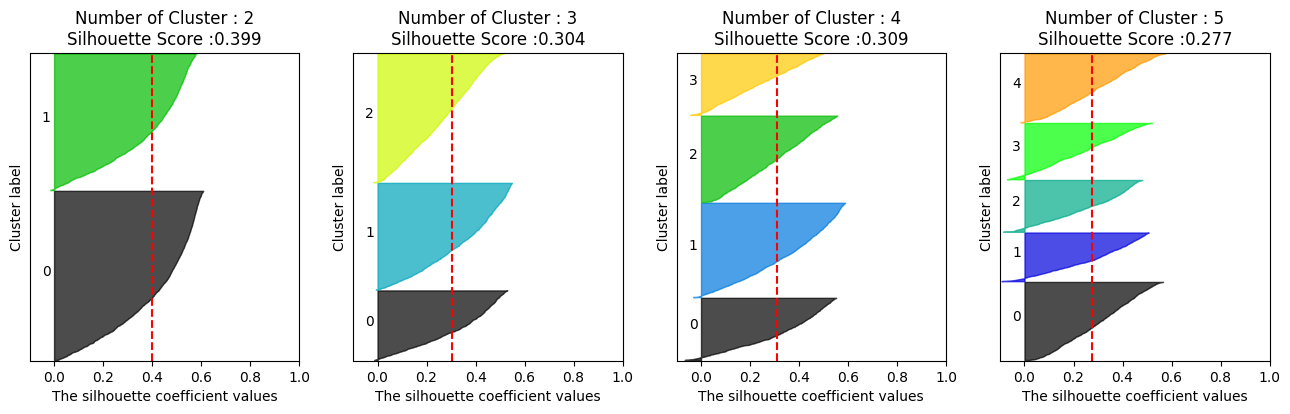

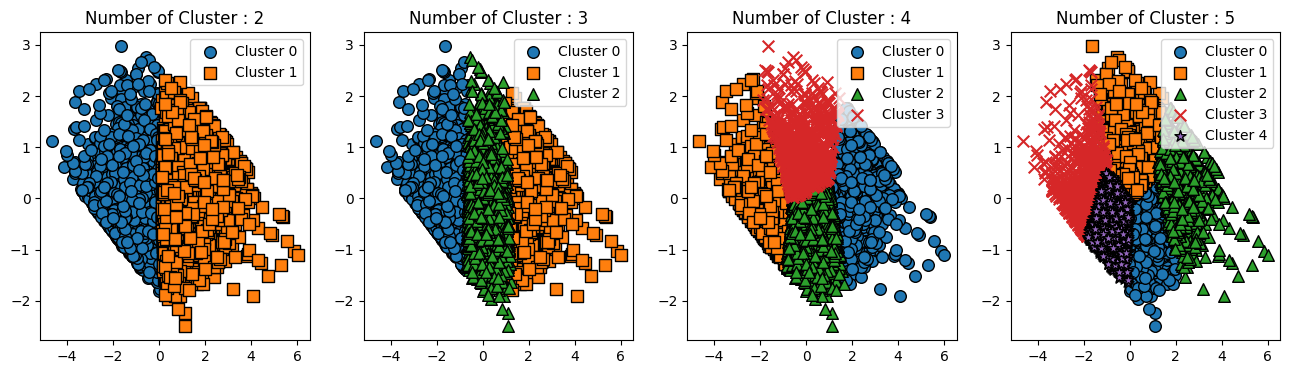

In [46]:
visualize_silhouette([2,3,4,5],X_features_scaled)
visualize_kmeans_plot_multi([2,3,4,5],X_features_scaled)

In [61]:
cust_df.shape

(4338, 8)

> **분석 결과 3차원 시각화**

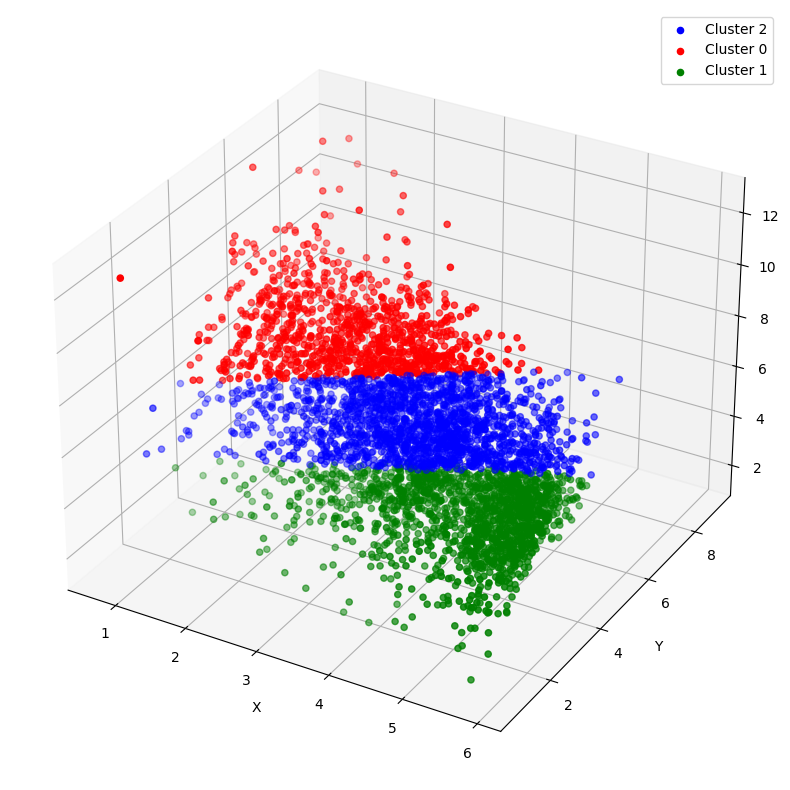

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y', 'c', 'm']
for cluster_label in cust_df['cluster_label'].unique():
    subset = cust_df[cust_df['cluster_label'] == cluster_label]
    ax.scatter(subset['Recency_log'], subset['Frequency_log'], subset['Monetary_log'], c=colors[cluster_label], label=f'Cluster {cluster_label}')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

> **각 군집별 column의 분포**

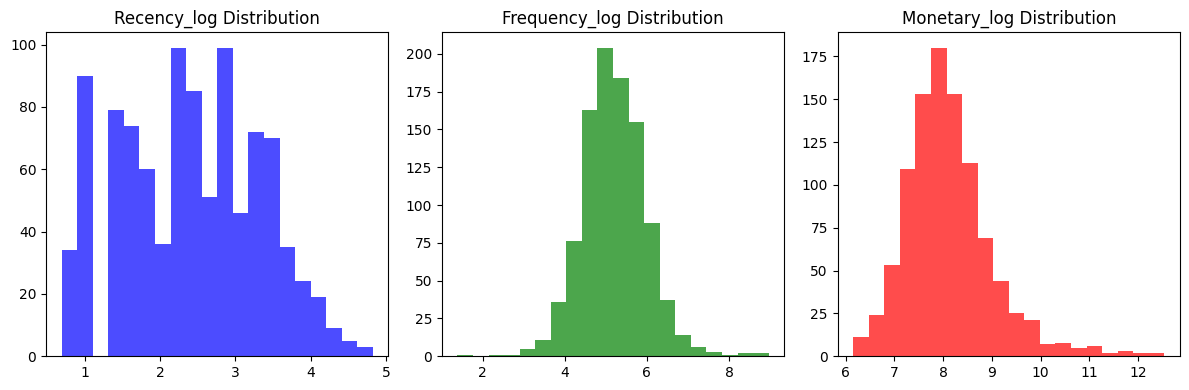

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

# cluster_labels: 각 데이터 포인트에 할당된 군집 번호를 나타내는 배열
# cust_df : 군집 분석에 사용된 데이터

# 각 군집별로 데이터를 분리
cluster_0_data = cust_df[cust_df['cluster_label'] == 0]
cluster_1_data = cust_df[cust_df['cluster_label'] == 1]
cluster_2_data = cust_df[cust_df['cluster_label'] == 2]

# 각 컬럼의 이름과 해당하는 데이터를 추출
recency_log = cluster_0_data['Recency_log']
frequency_log = cluster_0_data['Frequency_log']
monetary_log = cluster_0_data['Monetary_log']

# 히스토그램 그리기
plt.figure(figsize=(12, 4))

# Recency_log에 대한 히스토그램
plt.subplot(1, 3, 1)
plt.hist(recency_log, bins=20, color='blue', alpha=0.7)
plt.title('Recency_log Distribution')

# Frequency_log에 대한 히스토그램
plt.subplot(1, 3, 2)
plt.hist(frequency_log, bins=20, color='green', alpha=0.7)
plt.title('Frequency_log Distribution')

# Monetary_log에 대한 히스토그램
plt.subplot(1, 3, 3)
plt.hist(monetary_log, bins=20, color='red', alpha=0.7)
plt.title('Monetary_log Distribution')

plt.tight_layout()
plt.show()


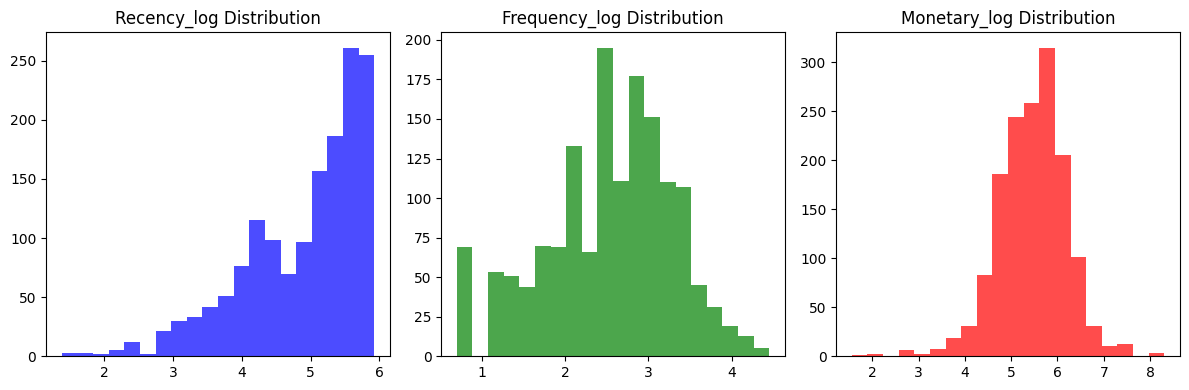

In [78]:
# 각 컬럼의 이름과 해당하는 데이터를 추출
recency_log = cluster_1_data['Recency_log']
frequency_log = cluster_1_data['Frequency_log']
monetary_log = cluster_1_data['Monetary_log']

# 히스토그램 그리기
plt.figure(figsize=(12, 4))

# Recency_log에 대한 히스토그램
plt.subplot(1, 3, 1)
plt.hist(recency_log, bins=20, color='blue', alpha=0.7)
plt.title('Recency_log Distribution')

# Frequency_log에 대한 히스토그램
plt.subplot(1, 3, 2)
plt.hist(frequency_log, bins=20, color='green', alpha=0.7)
plt.title('Frequency_log Distribution')

# Monetary_log에 대한 히스토그램
plt.subplot(1, 3, 3)
plt.hist(monetary_log, bins=20, color='red', alpha=0.7)
plt.title('Monetary_log Distribution')

plt.tight_layout()
plt.show()

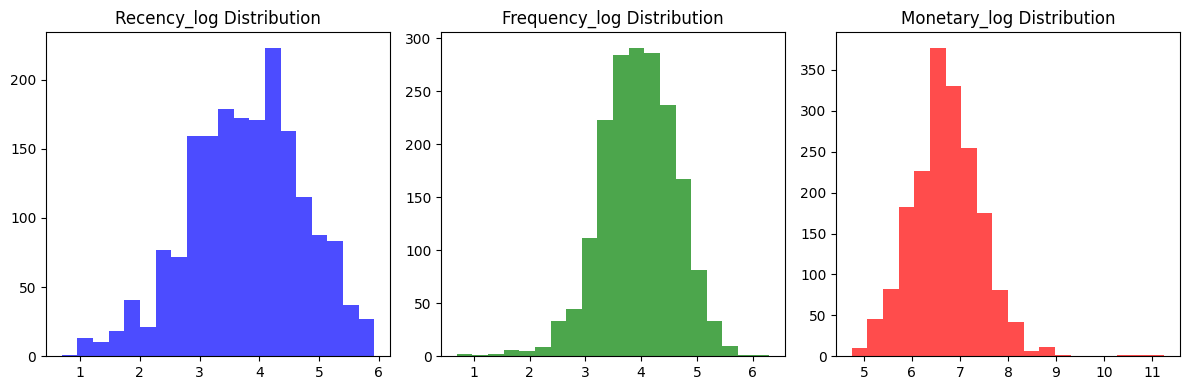

In [79]:
# 각 컬럼의 이름과 해당하는 데이터를 추출
recency_log = cluster_2_data['Recency_log']
frequency_log = cluster_2_data['Frequency_log']
monetary_log = cluster_2_data['Monetary_log']

# 히스토그램 그리기
plt.figure(figsize=(12, 4))

# Recency_log에 대한 히스토그램
plt.subplot(1, 3, 1)
plt.hist(recency_log, bins=20, color='blue', alpha=0.7)
plt.title('Recency_log Distribution')

# Frequency_log에 대한 히스토그램
plt.subplot(1, 3, 2)
plt.hist(frequency_log, bins=20, color='green', alpha=0.7)
plt.title('Frequency_log Distribution')

# Monetary_log에 대한 히스토그램
plt.subplot(1, 3, 3)
plt.hist(monetary_log, bins=20, color='red', alpha=0.7)
plt.title('Monetary_log Distribution')

plt.tight_layout()
plt.show()

In [80]:
cluster_0_data.describe()

,CustomerID,Recency,Frequency,Monetary,cluster_label,Recency_log,Frequency_log,Monetary_log
count,990.000000,990.000000,990.000000,990.000000,990.0,990.000000,990.000000,990.000000
mean,15170.430303,15.418182,262.180808,6452.118525,0.0,2.392153,5.206199,8.123188
std,1750.827962,16.099943,431.484707,17829.636458,0.0,0.913203,0.780908,0.902649
min,12347.000000,1.000000,3.000000,469.480000,0.0,0.693147,1.386294,6.153753
25%,13655.000000,4.000000,110.000000,1899.902500,0.0,1.609438,4.709530,7.550083
50%,15071.500000,10.000000,176.000000,2980.320000,0.0,2.397895,5.176150,8.000120
75%,16728.250000,21.500000,293.750000,5110.462500,0.0,3.112751,5.686126,8.539240
max,18283.000000,124.000000,7847.000000,280206.020000,0.0,4.828314,8.968014,12.543284


In [81]:
cluster_1_data.describe()

,CustomerID,Recency,Frequency,Monetary,cluster_label,Recency_log,Frequency_log,Monetary_log
count,1519.000000,1519.000000,1519.000000,1519.000000,1519.0,1519.000000,1519.000000,1519.000000
mean,15394.305464,176.898618,15.423305,302.433483,1.0,4.898087,2.529307,5.453710
std,1716.564262,108.311092,12.006334,277.477878,0.0,0.870182,0.781333,0.734262
min,12350.000000,3.000000,1.000000,3.750000,1.0,1.386294,0.693147,1.558145
25%,13907.500000,74.000000,7.000000,148.325000,1.0,4.317488,2.079442,5.006125
50%,15389.000000,177.000000,13.000000,242.350000,1.0,5.181784,2.639057,5.494501
75%,16848.500000,267.000000,21.000000,372.870000,1.0,5.590987,3.091042,5.923906
max,18281.000000,374.000000,85.000000,4055.720000,1.0,5.926926,4.454347,8.308130


In [82]:
cluster_2_data.describe()

,CustomerID,Recency,Frequency,Monetary,cluster_label,Recency_log,Frequency_log,Monetary_log
count,1829.000000,1829.000000,1829.000000,1829.000000,1829.0,1829.000000,1829.000000,1829.000000
mean,15292.779661,65.455987,62.819574,1128.711921,2.0,3.785716,3.945092,6.712418
std,1706.395636,63.096717,43.904676,2404.023619,0.0,0.951544,0.670231,0.709026
min,12346.000000,1.000000,1.000000,114.340000,2.0,0.693147,0.693147,4.747884
25%,13812.000000,23.000000,32.000000,524.140000,2.0,3.178054,3.496508,6.263665
50%,15320.000000,45.000000,52.000000,803.560000,2.0,3.828641,3.970292,6.690296
75%,16732.000000,82.000000,82.000000,1297.870000,2.0,4.418841,4.418841,7.169250
max,18287.000000,373.000000,543.000000,77183.600000,2.0,5.924256,6.298949,11.253955


클러스터링을 수행한 후에는 각 개별 군집의 특성을 파악하기 위해 다양한 방법을 사용할 수 있습니다. 가장 일반적인 방법 중 하나는 각 군집의 중심 또는 대표점을 계산하여 해당 군집의 특성을 파악하는 것입니다. 또한, 각 군집의 데이터 포인트들 간의 유사성을 분석하고 이를 기반으로 군집의 특성을 이해할 수도 있습니다. 이를 위해 다음과 같은 방법을 사용할 수 있습니다:

1. **군집 중심 분석**: 각 군집의 중심을 계산하여 군집의 중심점이 가지는 특성을 이해합니다. 이는 K-평균 클러스터링과 같은 알고리즘에서 특히 유용합니다. 중심은 해당 군집의 대표값으로 사용되며, 이를 통해 군집의 특성을 파악할 수 있습니다.

2. **군집 내 데이터 분포 분석**: 각 군집에 속한 데이터 포인트들의 분포를 분석하여 군집의 특성을 이해합니다. 이를 통해 군집의 데이터가 어떤 패턴을 가지고 있는지, 어떤 특징을 공유하고 있는지를 파악할 수 있습니다.

3. **군집 간 비교**: 서로 다른 군집 간에 특성을 비교하여 차이점을 파악할 수 있습니다. 이를 통해 각 군집이 어떤 특성을 가지고 있는지 더 잘 이해할 수 있습니다.

4. **시각화**: 군집화 결과를 시각적으로 표현하여 각 군집의 특성을 파악할 수 있습니다. 산점도나 히스토그램 등의 시각화 기법을 사용하여 각 군집의 특징을 시각적으로 확인할 수 있습니다.
- 산점도 (Scatter plot): 각 군집에 속한 데이터 포인트들을 2차원 평면 상에 표시하여 군집 간의 분포를 비교할 수 있습니다. 이를 통해 데이터의 군집화가 얼마나 잘 이루어졌는지, 각 군집의 경향성이 어떻게 다른지를 시각적으로 확인할 수 있습니다.

- 히스토그램 (Histogram): 각 군집에 속한 데이터의 분포를 확인할 수 있습니다. 이를 통해 각 군집의 데이터가 어떤 범위에 집중되어 있는지, 데이터의 밀도가 어떻게 분포되어 있는지를 확인할 수 있습니다.

- 클러스터링 플롯 (Cluster plot): 다차원 데이터를 2차원으로 축소하여 각 군집을 시각화하는 방법입니다. 주로 차원 축소 기법인 t-SNE 또는 PCA를 사용하여 시각화합니다. 이를 통해 각 군집의 상대적 위치와 군집 간의 거리를 확인할 수 있습니다.

- 실루엣 다이어그램 (Silhouette diagram): 각 데이터 포인트의 실루엣 계수를 시각화하여 군집의 응집력과 분리도를 확인할 수 있습니다. 이를 통해 군집이 얼마나 잘 형성되었는지, 군집 간의 분리가 얼마나 명확한지를 판단할 수 있습니다.

- 밀도 기반 시각화 (Density-based visualization): 밀도 기반 클러스터링 결과를 시각화하여 각 군집의 밀도와 모양을 확인할 수 있습니다. 주로 KDE (Kernel Density Estimation) 또는 등고선 플롯을 사용하여 시각화합니다.

1. **시각화**: 클러스터링 결과를 시각화하여 각 클러스터의 특징을 파악할 수 있습니다. 주성분 분석(PCA), t-SNE 등의 차원 축소 기법을 사용하여 데이터를 2차원 또는 3차원 공간에 표현하고, 클러스터가 어떻게 분포되어 있는지 확인할 수 있습니다.

2. **통계적 분석**: 각 클러스터의 특징을 분석하기 위해 통계적 방법을 사용할 수 있습니다. 각 클러스터의 평균, 중앙값, 표준편차 등을 계산하여 클러스터의 중심적 경향과 분산을 파악할 수 있습니다.

3. **클러스터링 특성 확인**: 클러스터에 속한 데이터 포인트들의 특성을 확인하여 클러스터의 특징을 파악할 수 있습니다. 예를 들어, 주어진 클러스터에 속한 데이터 포인트들이 특정 범주에 속하는 경우 해당 범주의 특징을 파악할 수 있습니다.

4. **도메인 지식 활용**: 클러스터링 결과를 도메인 지식과 연결하여 해석할 수 있습니다. 예를 들어, 의료 분야에서 환자 데이터를 클러스터링한 경우 각 클러스터가 어떤 질병이나 증상을 나타내는지 도메인 지식을 활용하여 해석할 수 있습니다.

이러한 방법들을 조합하여 클러스터링 결과를 분석하고 각 클러스터의 특징을 파악할 수 있습니다. 종종 클러스터링은 데이터를 자동으로 묶는 기법이지만, 클러스터링 결과를 해석하는 것은 분석가의 역할입니다.

**추가 정보:**
클러스터링 결과를 해석하는 데 도움이 되는 도구로는 실루엣 스코어(Silhouette Score), 엘보우 메서드(Elbow Method) 등이 있습니다. 이러한 도구들을 사용하여 클러스터링 결과를 평가하고 최적의 클러스터 개수를 결정할 수 있습니다.